# Transfer Learning with VGG-16 pre-trained on ImageNet


We abandon MNIST for a more complex dataset of natural images of Ants and Bees. 

<img src="../NotebooksFigures/ants_and_bees.jpg" alt="drawing" width="600" >

Being the data much more complex we will need a very large convolutional network to train on, but at the same time - since our dataset is relatively small ($\approx$ 300 images between training and validation set) - we cannot train it from scratch.
Having observed that the first layers of a large convolutional network learn representations which can be universally useful for object recognition purposes, we will a very large one, specifically VGG-16 pre-trained on ImageNet - as a feature extractor.

<img src="../NotebooksFigures/vgg16.png" alt="drawing" width="200" >


On top of the VGG-16 - maimed of its classifier stack - we will add a brand new classifier stack with the correct output shape, train it for a few epochs, and finally test it on our data.

This operation is commonly denoted *transfer* learning.




In this exercise we will learn how to :

- download a pre-trained model
- prepare a dataset for a (binary) classification problem
- extract the representations (features) at the end of the convolutional stack
- fit a classifier stack to the new dataset, this classifier will be identical to the classifier stack of the original VGG-16, a part from the output shape
- evaluate the model obtained on validation data
- look at the errors

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.utils import to_categorical
import os
from keras.preprocessing.image import ImageDataGenerator, load_img

# Instantiate a pre-trained VGG-16 without its classifier stack

In [13]:
from keras.applications import VGG16
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [14]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
train_dir = './data/hymenoptera_data/train'
validation_dir = './data/hymenoptera_data/val'

nTrain = 600
nVal = 150

In [21]:
#delete 4 images from train/ants

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,2))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break
        
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

Found 240 images belonging to 2 classes.


In [23]:
batch_size = 10

validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,2))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 150 images belonging to 2 classes.


In [25]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 600 samples, validate on 150 samples
Epoch 1/20
600/600 [==============================] - 5s 9ms/step - loss: 1.0485 - acc: 0.7233 - val_loss: 1.0580 - val_acc: 0.6133
Epoch 2/20
600/600 [==============================] - 5s 8ms/step - loss: 0.3621 - acc: 0.8717 - val_loss: 0.4472 - val_acc: 0.8467
Epoch 3/20
600/600 [==============================] - 5s 8ms/step - loss: 0.1525 - acc: 0.9433 - val_loss: 0.4672 - val_acc: 0.8400
Epoch 4/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0922 - acc: 0.9667 - val_loss: 1.2641 - val_acc: 0.7400
Epoch 5/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0516 - acc: 0.9883 - val_loss: 1.2754 - val_acc: 0.7333
Epoch 6/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0466 - acc: 0.9817 - val_loss: 1.2454 - val_acc: 0.7800
Epoch 7/20
600/600 [==============================] - 5s 8ms/step - loss: 0.0091 - acc: 0.9950 - val_loss: 0.7205 - val_acc: 0.8467
Epoch 8/20
600/600 [==========

In [27]:
fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

In [28]:
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)

In [30]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 21/150


Original label:ants, Prediction :bees, confidence : 0.999


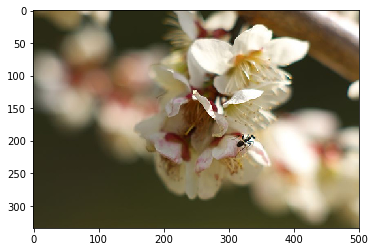

Original label:ants, Prediction :bees, confidence : 1.000


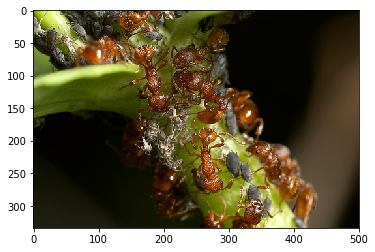

Original label:ants, Prediction :bees, confidence : 1.000


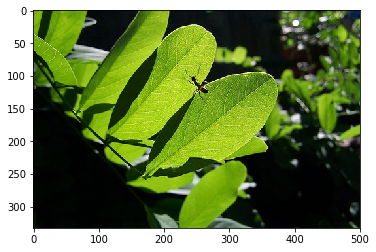

Original label:ants, Prediction :bees, confidence : 0.592


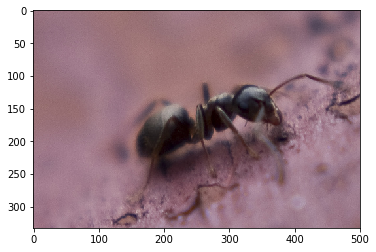

Original label:ants, Prediction :bees, confidence : 0.526


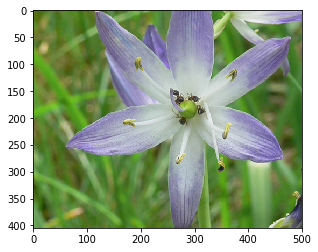

Original label:ants, Prediction :bees, confidence : 0.949


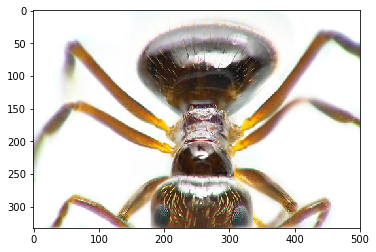

Original label:ants, Prediction :bees, confidence : 1.000


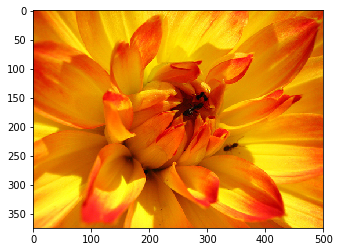

Original label:bees, Prediction :ants, confidence : 1.000


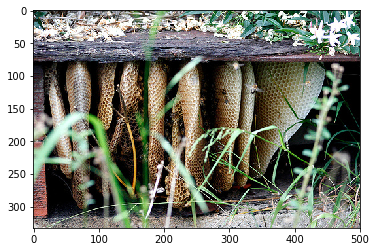

Original label:bees, Prediction :ants, confidence : 0.637


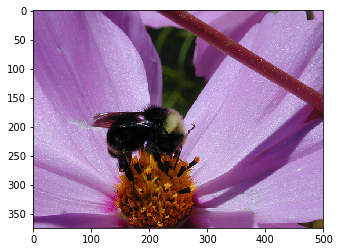

Original label:bees, Prediction :ants, confidence : 0.893


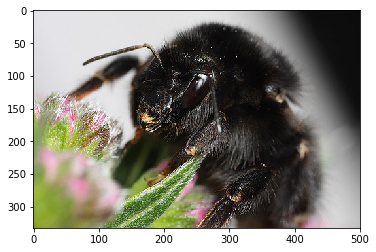

Original label:bees, Prediction :ants, confidence : 1.000


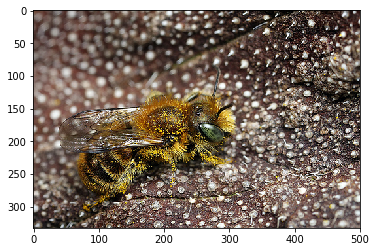

Original label:bees, Prediction :ants, confidence : 1.000


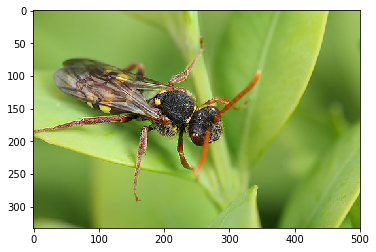

Original label:bees, Prediction :ants, confidence : 1.000


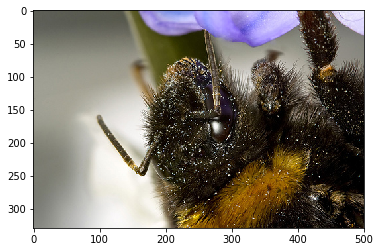

Original label:bees, Prediction :ants, confidence : 1.000


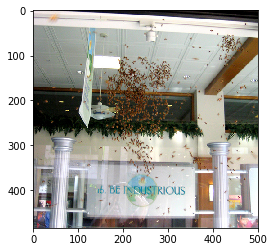

Original label:bees, Prediction :ants, confidence : 1.000


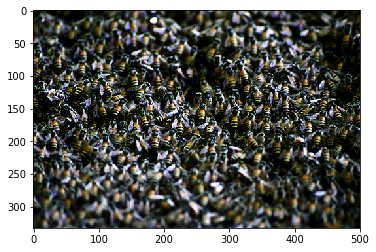

Original label:bees, Prediction :ants, confidence : 0.976


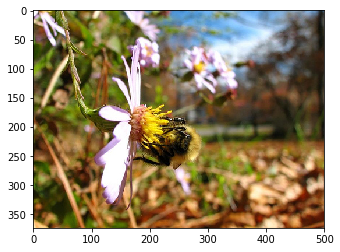

Original label:bees, Prediction :ants, confidence : 0.992


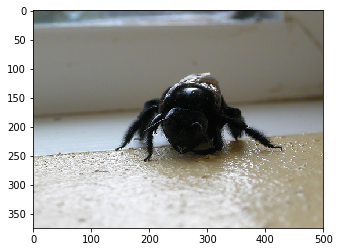

Original label:bees, Prediction :ants, confidence : 1.000


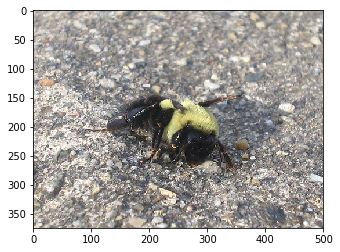

Original label:bees, Prediction :ants, confidence : 0.995


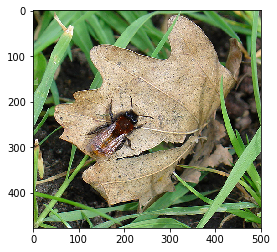

Original label:bees, Prediction :ants, confidence : 0.968


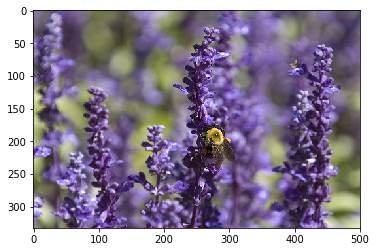

Original label:bees, Prediction :ants, confidence : 0.989


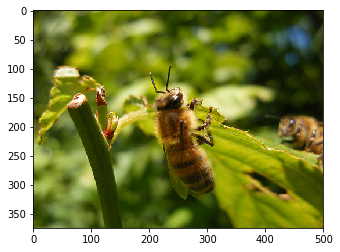

In [31]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()